# SMART-QSO Power/Energy Simulation (1 s resolution)

This notebook simulates the spacecraft power/energy balance at 1 s resolution across the ConOps phases (LEOP, Commissioning, Nominal Ops, EOL) using simplified orbit lighting and subsystem load models.

- Orbit lighting: configurable orbit period and sunlit duration per orbit (cylindrical shadow approximation)
- Solar generation: constant panel output in sunlit portions with scale factors for attitude/seasonal effects
- Battery model: simple coulomb counter with charge/discharge efficiency and SOC limits
- Subsystem loads: OBC base, Beacon (stochastic cadence), ADCS (detumble), Jetson payload (power-aware gating), heaters (optional)

Defaults use compressed durations for demonstration. Adjust config to match mission assumptions. Refer to `mission/CONOPS.md` for phase definitions.


In [14]:
# Config: orbit, panels, battery, subsystems
from dataclasses import dataclass

@dataclass
class OrbitConfig:
    period_s: int = 5400          # 90 min
    sunlit_s: int = 3000          # ~55% sunlit
    sim_dt_s: int = 1

@dataclass
class PanelConfig:
    sunlit_w: float = 10.0        # average sunlit array generation [W]
    eclipse_w: float = 0.1        # leakage/reflection [W]
    scale: float = 1.0            # seasonal/attitude scaling

@dataclass
class BatteryConfig:
    capacity_wh: float = 30.0     # usable Wh
    charge_eff: float = 0.95
    discharge_eff: float = 0.95
    soc_min: float = 0.05         # 5% reserve

@dataclass
class LoadsConfig:
    obc_w: float = 0.3
    beacon_w: float = 0.5         # avg during emission (short duty)
    adcs_detumble_w: float = 0.8
    adcs_idle_w: float = 0.1
    jetson_w: float = 8.0         # declocked burst avg when on
    heaters_w: float = 0.0

@dataclass
class ConOpsDurations:
    leop_s: int = 2*3600          # 2 h (compress for demo)
    commissioning_s: int = 6*3600 # 6 h
    nominal_s: int = 24*3600      # 1 day
    eol_s: int = 1*3600           # 1 h

orbit = OrbitConfig()
panels = PanelConfig()
batt = BatteryConfig()
loads = LoadsConfig()
phases = ConOpsDurations()

# Mission gating thresholds
SOC_JETSON_EN = 0.60
SOC_SAFE_MODE = 0.25


In [15]:
# Helpers: orbit lighting, coulomb counter, stochastic beacon
import math
import random

random.seed(0)

def is_sunlit(t: int, orbit: OrbitConfig) -> bool:
    t_mod = t % orbit.period_s
    return t_mod < orbit.sunlit_s

class Battery:
    def __init__(self, cfg: BatteryConfig):
        self.cfg = cfg
        self.energy_wh = cfg.capacity_wh * 0.8  # start at 80% SOC
    @property
    def soc(self) -> float:
        return max(0.0, min(1.0, self.energy_wh / self.cfg.capacity_wh))
    def charge(self, p_w: float, dt_s: int):
        # p_w > 0 adds energy
        wh = (p_w * dt_s) / 3600.0
        self.energy_wh += wh * self.cfg.charge_eff
        if self.energy_wh > self.cfg.capacity_wh:
            self.energy_wh = self.cfg.capacity_wh
    def discharge(self, p_w: float, dt_s: int):
        # p_w > 0 draws energy
        wh = (p_w * dt_s) / 3600.0
        self.energy_wh -= wh / max(1e-6, self.cfg.discharge_eff)
        if self.energy_wh < 0.0:
            self.energy_wh = 0.0

def beacon_on_this_second(avg_interval_s: int) -> bool:
    # Approximate Poisson: trigger with probability dt/mean
    if avg_interval_s <= 0:
        return False
    return random.random() < (1.0 / float(avg_interval_s))



In [16]:
# Mission simulation
import numpy as np

bt = Battery(batt)

# Phase schedule (compressed for demo)
phases_s = [
    ("LEOP", phases.leop_s),
    ("COMMISSIONING", phases.commissioning_s),
    ("NOMINAL", phases.nominal_s),
    ("EOL", phases.eol_s),
]

# Beacon cadence by phase (average seconds between emissions)
beacon_avg = {
    "LEOP": 120,
    "COMMISSIONING": 90,
    "NOMINAL": 60,
    "EOL": 180,
}

T_total = sum(d for _, d in phases_s)

soc_log = np.zeros(T_total, dtype=float)
load_w_log = np.zeros(T_total, dtype=float)
solar_w_log = np.zeros(T_total, dtype=float)
mode_log = []

for t in range(T_total):
    # Determine phase
    acc = 0
    for name, dur in phases_s:
        if t < acc + dur:
            phase = name
            break
        acc += dur

    sun = is_sunlit(t, orbit)
    solar_w = panels.sunlit_w * panels.scale if sun else panels.eclipse_w

    # Base loads
    p_load = loads.obc_w + loads.adcs_idle_w + loads.heaters_w

    # Detumble in LEOP initially (first 20 min)
    if phase == "LEOP" and t < 20*60:
        p_load += loads.adcs_detumble_w

    # Beacon stochastic draw when emitting (short duty)
    if beacon_on_this_second(beacon_avg[phase]):
        p_load += loads.beacon_w

    # Jetson gating by SOC and sunlit
    if (bt.soc >= SOC_JETSON_EN) and sun and (phase in ("COMMISSIONING", "NOMINAL")):
        p_load += loads.jetson_w

    net_w = solar_w - p_load
    if net_w >= 0:
        bt.charge(net_w, orbit.sim_dt_s)
    else:
        bt.discharge(-net_w, orbit.sim_dt_s)

    soc_log[t] = bt.soc
    load_w_log[t] = p_load
    solar_w_log[t] = solar_w
    mode_log.append(phase)

# Simple summary
print(f"End SOC: {bt.soc*100:.1f}% after {T_total/3600:.1f} h simulated")


End SOC: 99.3% after 33.0 h simulated


Matplotlib is building the font cache; this may take a moment.


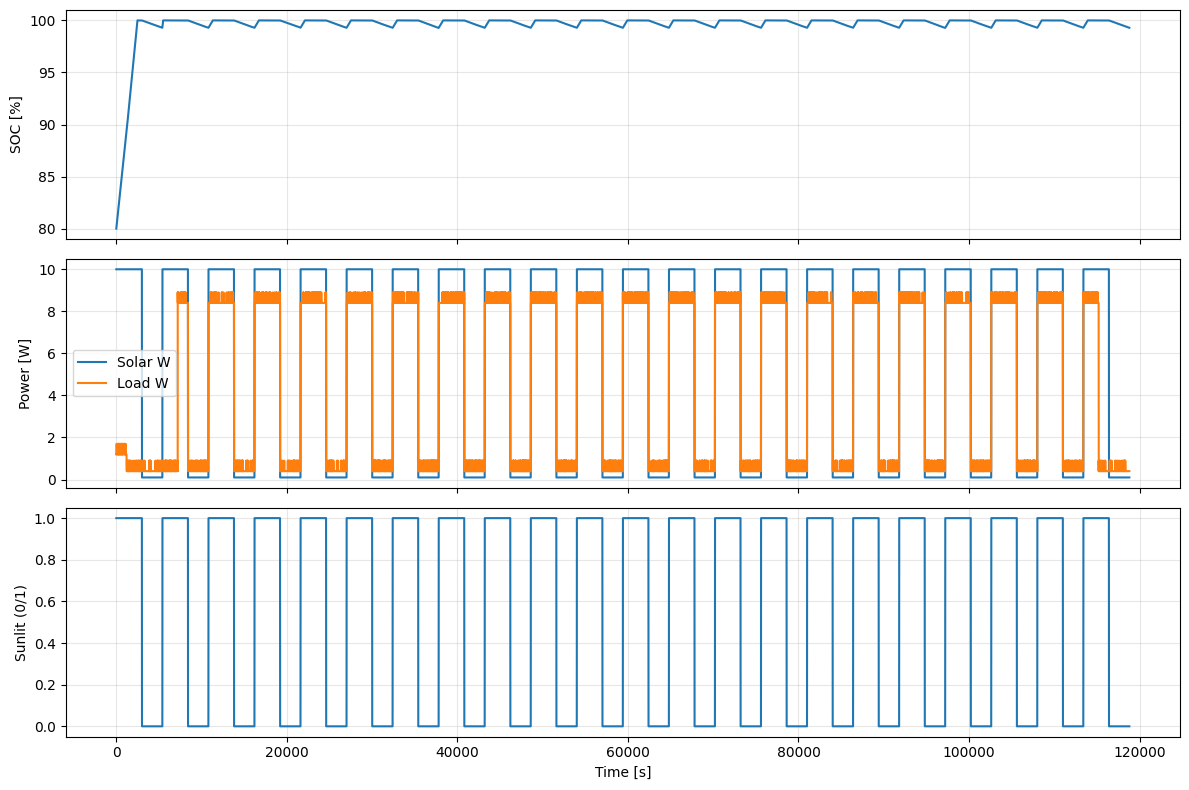

In [17]:
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
ax[0].plot(soc_log*100.0)
ax[0].set_ylabel('SOC [%]')
ax[0].grid(True, alpha=0.3)

ax[1].plot(solar_w_log, label='Solar W')
ax[1].plot(load_w_log, label='Load W')
ax[1].legend(); ax[1].set_ylabel('Power [W]')
ax[1].grid(True, alpha=0.3)

ax[2].plot([1 if is_sunlit(t, orbit) else 0 for t in range(len(soc_log))])
ax[2].set_ylabel('Sunlit (0/1)'); ax[2].set_xlabel('Time [s]')
ax[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# Metrics summary
# Power Positive: True if SoC never dips below the configured reserve (e.g., 5%)
power_positive = bool(np.all(soc_log >= batt.soc_min))

# Average battery SoC over the full simulation window (fraction)
avg_soc = float(np.mean(soc_log))

print("Power Positive:", power_positive)
print(f"Average battery SoC: {avg_soc*100:.2f}%")



Power Positive: True
Average battery SoC: 99.60%
